# Project Phase 1 
## SimBoost


#### Name: Alireza Akbari
#### Student No.: 95105379

Drug discovery is a time-consuming, laborious, costly and high-risk process. According to a report by the Eastern Research Group (ERG), it usually takes 10-15 years to develop a new drug. However, the success rate of developing a new molecular entity is only 2.01%. \
Finding a compound that selectively binds to a particular protein is a highly challenging and typically expensive procedure in the drug development process. \
In this project we are going to implement [SimBoost](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5395521/#CR42) which is machine-learning approch for predicting drug–target binding affinities using gradient boosting.




We will be using [Davis](http://staff.cs.utu.fi/~aatapa/data/DrugTarget/) dataset, which contains selectivity assays of the kinase protein family and the relevant inhibitors with their respective dissociation constant (Kd) values. It comprises interactions of 442 proteins and 68 drugs.

## 1. Setup (15 Points)

### 1.1 Imports libs

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### 1.2 Loading data

We need following files for this project:
- `target_gene_names.txt`: gene names of the targets
- `drug_PubChem_CIDs.txt`: PubChem CIDs of the drugs
- `drug-drug_similarities_2D.txt`: drug-drug structural fingerprint similarities computed the Structure Clustering sever at PubChem
- `target-target_similarities_WS_normalized.txt`: target-target sequence similarities computed with the normalized versions of the Smith-Waterman (SW) score.
- `drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt`: drug-target interaction affinities.

The rows (and columns) of the drug-drug similarity matrices correspond to the rows of the interaction affinity matrix and the rows (and columns) of the target-target similarity matrices correspond to the columns of the interaction affinity matrix.

In [2]:
target_gene_names = pd.read_csv("target_gene_names.txt", header=None, index_col = 0)
drug_pubchemIDs = pd.read_csv("drug_PubChem_CIDs.txt", header=None, index_col = 0) #  dtype=str

#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Load each file using pd.read_csv and use target_gene_names and drug_pubchemIDs
# to correspond row index and columns of all three files.
# sim_targets.shape == (442, 442)
# sim_drugs.shape == (68, 68)
# bindings.shape == (68, 442)
# Note that target_gene_names and drug_pubchemIDs dataframes are empty, we are
# going to fill them with features.
#################################################################################

sim_targets = pd.read_csv("target-target_similarities_WS_normalized.txt", header=None, index_col=None, sep=' ')
sim_targets.columns, sim_targets.index = target_gene_names.index.tolist(), target_gene_names.index.tolist()

sim_drugs = pd.read_csv("drug-drug_similarities_2D.txt", header=None, index_col=None, sep=' ')
sim_drugs.columns, sim_drugs.index = drug_pubchemIDs.index.tolist(), drug_pubchemIDs.index.tolist()

bindings = pd.read_csv("drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt", header=None, index_col=None, sep=' ')
bindings.columns, bindings.index = target_gene_names.index.tolist(), drug_pubchemIDs.index.tolist()

#################################################################################
#                                   THE END                                     #
#################################################################################
sim_targets.shape, sim_drugs.shape, bindings.shape

((442, 442), (68, 68), (68, 442))

### 1.3 Preprocessing

In davis dataset, standard value is Kd in nM. we used the transformation below:

### $pK_{d}=-log_{10}\frac{K_d}{1e9}$ 


In [3]:
drug_pubchemIDs.sort_index(inplace=True)
target_gene_names.sort_index(inplace=True)

#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# sort sim_targets, sim_drugs, bindings based on their index like above 
# divide all values of sim_targets by 100
# transform binding values as mentioned above
#################################################################################
sim_targets = sim_targets.sort_index(axis="index") / 100
sim_drugs = sim_drugs.sort_index(axis="index")
transformed_bindings = -1 * np.log10(bindings.sort_index(axis="index")/(1e9))

#################################################################################
#                                   THE END                                     #
#################################################################################

transformed_bindings.head()

,AAK1,ABL1(E255K)-phosphorylated,ABL1(F317I)-nonphosphorylated,ABL1(F317I)-phosphorylated,ABL1(F317L)-nonphosphorylated,ABL1(F317L)-phosphorylated,ABL1(H396P)-nonphosphorylated,ABL1(H396P)-phosphorylated,ABL1(M351T)-phosphorylated,ABL1(Q252H)-nonphosphorylated,...,WEE1,WEE2,YANK1,YANK2,YANK3,YES,YSK1,YSK4,ZAK,ZAP70
5291,5.000000,6.769551,8.080922,6.236572,8.602060,6.958607,8.229148,7.187087,7.356547,8.744727,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.585027,5.000000
44259,8.920819,7.657577,6.259637,6.886057,6.769551,7.337242,7.744727,7.443697,7.283997,7.677781,...,5.795880,5.000000,7.886057,7.008774,6.508638,7.283997,6.958607,9.065502,5.000000,7.356547
123631,5.000000,6.397940,5.000000,5.327902,5.568636,6.107905,6.167491,6.337242,6.283997,5.958607,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.619789,5.000000,5.000000
126565,8.508638,6.075721,5.000000,5.309804,5.119186,5.657577,6.000000,6.060481,6.107905,5.602060,...,5.920819,5.102373,5.677781,5.229148,5.096910,6.795880,7.013228,9.283997,5.173925,7.795880
151194,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.721246,5.356547,5.000000


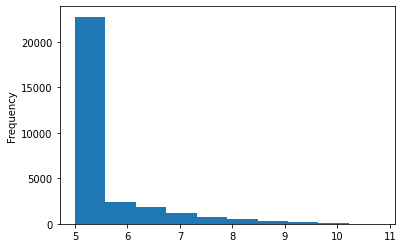

In [4]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Plot histogram of all values in transformed_bindings
# Hint: use .stack and .plot.hist  
#################################################################################
transformed_bindings.stack().plot.hist()
#################################################################################
#                                   THE END                                     #
#################################################################################

As you can see in histogram. The peak at pKd value 5 (10000 nM), These values correspond to the negative pairs that either have very weak binding affinities (Kd > 10000nM) or are not observed in the primary screen.

### 1.4 Drug-Target-Binding

In [5]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# use drug_target_binding and build drug_target_binding dataframe 
# in each row of dataframe you must have one drug-target pair and their 
# transformed binding value, in the end you must have a dataframe with 
# 30056 row and 3 columns ['Drug', 'Target', 'Binding_Val']
#################################################################################
drug_target_binding = pd.melt(transformed_bindings.assign(Drug=transformed_bindings.index), id_vars='Drug', var_name = 'Target', value_name='Binding_Val')

#################################################################################
#                                   THE END                                     #
#################################################################################
print(drug_target_binding.shape)
drug_target_binding

(30056, 3)


,Drug,Target,Binding_Val
0,5291,AAK1,5.000000
1,44259,AAK1,8.920819
2,123631,AAK1,5.000000
3,126565,AAK1,8.508638
4,151194,AAK1,5.000000
...,...,...,...
30051,25127112,ZAP70,5.000000
30052,25243800,ZAP70,5.000000
30053,42642645,ZAP70,5.000000
30054,44150621,ZAP70,5.000000


### 1.5 Train, Validation and Test Datasets

In [6]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# split drug_target_binding dataframe to 3 sets (train_data, val_data, test_data)
# split ratio is up to you
# at the end you must have 3 sets that each of them has 3 columns
#################################################################################
train_data, test_data = train_test_split(drug_target_binding, test_size=0.2, random_state=2)
train_data, val_data = train_test_split(train_data, test_size=0.125, random_state=2)

#################################################################################
#                                   THE END                                     #
#################################################################################

train_data.shape, val_data.shape, test_data.shape
train_data

,Drug,Target,Binding_Val
8420,16038120,EGFR(T790M),8.148742
68,5291,ABL1(E255K)-phosphorylated,6.769551
2579,25127112,AXL,5.000000
15765,16722836,MAPKAPK5,5.000000
1704,151194,AKT2,5.000000
...,...,...,...
4003,17755052,CAMKK1,5.000000
14508,5494449,LKB1,5.886057
20614,176870,PFTK1,5.000000
16562,10184653,MELK,5.000000


## 2.Feature Engineering (35 Points)

In this part we are going to extract some feature for each target/drug. after that we will replace these features with their names/pubchemIDs. 

### 2.1 Average Similarities and Binding values

In [7]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# for each target compute their average similarities in sim_targets matrix
# and average binding value (in train_data).
# add these two feature as 'avg-sim', 'avg-binding' to target_gene_names DataFrame
#################################################################################

target_gene_names['gene-avg-sim'] = sim_targets.mean().values
target_gene_names['gene-avg-binding'] = train_data.groupby("Target").mean()['Binding_Val'].values
#################################################################################
#                                   THE END                                     #
#################################################################################
target_gene_names.head()

,gene-avg-sim,gene-avg-binding
0,,
AAK1,0.479173,5.752241
ABL1(E255K)-phosphorylated,0.535796,6.075331
ABL1(F317I)-nonphosphorylated,0.535796,5.666564
ABL1(F317I)-phosphorylated,0.535796,5.635374
ABL1(F317L)-nonphosphorylated,0.535796,5.890240


In [8]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# for each drug compute their average similarities in sim_drugs matrix
# and average binding value (in train_data).
# add these two feature as 'avg-sim', 'avg-binding' to drug_pubchemIDs DataFrame
#################################################################################

drug_pubchemIDs['drug-avg-sim'] = sim_drugs.mean().values
drug_pubchemIDs['drug-avg-binding'] = train_data.groupby('Drug').mean().values
#################################################################################
#                                   THE END                                     #
#################################################################################
drug_pubchemIDs.head()

,drug-avg-sim,drug-avg-binding
0,,
5291,0.588485,5.203990
44259,0.560779,7.158989
123631,0.605632,5.260865
126565,0.526647,6.782608
151194,0.614324,5.070677


### 2.2 Drug/Target Similarity Networks

#### 2.2.1 Build Networks

You must build two networks one for drugs and another one for targets. The nodes are drugs or targets, and an edge between two nodes exists if their similarity is above a threshold. The value of threshold is up to you. \
For building networks, we are going to use [igraph](https://igraph.org/) package. 

In [9]:
import igraph

0.5603568339100345
0.5139319589614882


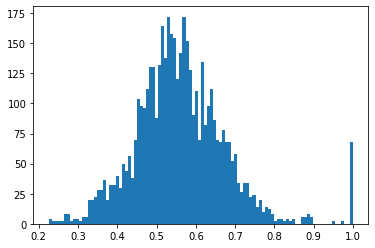

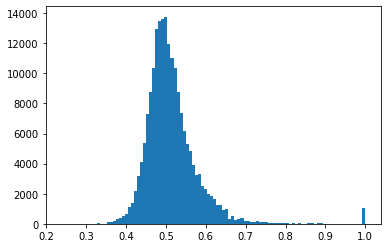

In [10]:
print(np.mean(sim_drugs.mean().values))
print(np.mean(sim_targets.mean().values))
plt.hist(sim_drugs.stack(), bins=100)
plt.show()
plt.hist(sim_targets.stack(), bins= 100)
plt.show()

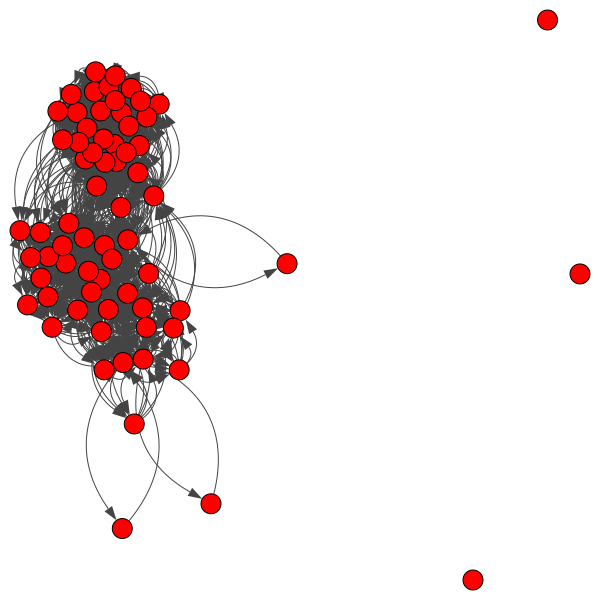

In [11]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# define drug_sim_threshold, target_sim_threshold and use these values to
# build two network one for drugs and another one for targets using sim_drugs
# and sim_targets.
# Hint: you can use igraph.Graph.Adjacency, you can plot your graph using 
# igraph.plot
#################################################################################
drug_sim_threshold = 0.6
target_sim_threshold = 0.55
sim_drugs = sim_drugs.sort_index(axis=1)
sim_targets = sim_targets.sort_index(axis=1)



np.fill_diagonal(sim_drugs.values, 0)
np.fill_diagonal(sim_targets.values, 0)
drug_graph = igraph.Graph.Adjacency((sim_drugs.values > drug_sim_threshold).tolist())
target_graph = igraph.Graph.Adjacency((sim_targets.values > target_sim_threshold).tolist())
#drug_graph.vs['label'] = sim_drugs.index.tolist()
#target_graph.vs['label'] = sim_targets.index.tolist()

igraph.plot(drug_graph)

#################################################################################
#                                   THE END                                     #
#################################################################################

Explain how you choose your threshold values? \
**First I calculated the average of similarities in both of the matrix. I didn't choose them as threshold because it's just the average and it can't be a good measure to recognize significance of similarity itself. So I wanted to check higher moments like variance so I plotted the histogram of similarities. I picked a threshold which seemed to be a good value to distinguish between normal similarity and meaningful similarity**

#### 2.2.2 Number of neighbors, PageRank

In [12]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# for each drug compute number of neighbors and it's PageRank score. 
# add these two feature as 'n_neighbors', 'page_rank' to drug_pubchemIDs DataFrame.
# do the above for each target too and add them to target_gene_names DataFrame.
# Hint: for pagerank score you can use graph.pagerank.
#################################################################################
drug_pubchemIDs['drug-n_neighbors'] = np.sum(sim_drugs.values > drug_sim_threshold, axis=0)
drug_pubchemIDs['drug-page_rank'] = np.array(drug_graph.pagerank())

target_gene_names['gene-n_neighbors'] = np.sum(sim_targets.values > target_sim_threshold, axis=0)
target_gene_names['gene-page_rank'] = np.array(target_graph.pagerank())
#################################################################################
#                                   THE END                                     #
#################################################################################
target_gene_names.head()
drug_pubchemIDs.head()

,drug-avg-sim,drug-avg-binding,drug-n_neighbors,drug-page_rank
0,,,,
5291,0.588485,5.203990,35,0.024630
44259,0.560779,7.158989,11,0.010012
123631,0.605632,5.260865,29,0.018039
126565,0.526647,6.782608,8,0.008045
151194,0.614324,5.070677,16,0.012512


### 2.3 Non-negative Matrix Factorization

For extracting features from binding affinity matrix we are going to use [Non-negative Matrix Factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization). 

In NMF, we are trying to approximately factor a matrix $B ∈ R_+^{d×t}$ (binding affinity matrix of d drugs and t targets) into two matrices $P ∈ R_+^{k×d}$ and $Q ∈ R_+^{k×t}$ which  $B = P^TQ$

In this problem, you can set $k$ (Latent dimension of $P$ and $Q$ matrices) to any number below 10.


The columns of the factor matrices P and Q are utilized as parts of the feature vectors for the drugs and targets respectively.

In [13]:
from sklearn.decomposition import NMF

In [14]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# define latent_dim variable, after that use train_data to build bindings matrix
# because we remove some of the bindings values when we choose train_data in part 1.5  
# your matrix will have some na values fill them with 5 (Which is lowest binding score).
#################################################################################
latent_dim = 7
train_binding_matrix = train_data.pivot(index='Drug', columns='Target', values='Binding_Val').fillna(5)
#################################################################################
#                                   THE END                                     #
#################################################################################
#train_data.pivot(index='Drug', columns='Target', values='Binding_Val')
train_binding_matrix.head()

Target,AAK1,ABL1(E255K)-phosphorylated,ABL1(F317I)-nonphosphorylated,ABL1(F317I)-phosphorylated,ABL1(F317L)-nonphosphorylated,ABL1(F317L)-phosphorylated,ABL1(H396P)-nonphosphorylated,ABL1(H396P)-phosphorylated,ABL1(M351T)-phosphorylated,ABL1(Q252H)-nonphosphorylated,...,YANK3,YES,YSK1,YSK4,ZAK,ZAP70,p38-alpha,p38-beta,p38-delta,p38-gamma
Drug,,,,,,,,,,,,,,,,,,,,,
5291,5.000000,6.769551,8.080922,6.236572,5.0,6.958607,5.000000,7.187087,7.356547,8.744727,...,5.00000,5.000000,5.000000,5.000000,5.585027,5.000000,5.0,5.0,5.0,5.0
44259,8.920819,7.657577,5.000000,6.886057,5.0,7.337242,7.744727,7.443697,7.283997,7.677781,...,5.00000,7.283997,6.958607,5.000000,5.000000,7.356547,5.0,5.0,5.0,5.0
123631,5.000000,5.000000,5.000000,5.327902,5.0,6.107905,6.167491,6.337242,6.283997,5.000000,...,5.00000,5.000000,5.000000,6.619789,5.000000,5.000000,5.0,5.0,5.0,5.0
126565,8.508638,6.075721,5.000000,5.309804,5.0,5.657577,6.000000,6.060481,6.107905,5.602060,...,5.09691,6.795880,7.013228,9.283997,5.000000,7.795880,5.0,5.0,5.0,5.0
151194,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.00000,5.000000,5.000000,5.721246,5.356547,5.000000,5.0,5.0,5.0,5.0


In [15]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Use sklearn NMF and factor 'train_binding_matrix' to P and Q.
# add columns of P and Q as features to 'drug_pubchemIDs' and 'target_gene_names'
#################################################################################
model = NMF(n_components=latent_dim, random_state=1)
P = model.fit_transform(train_binding_matrix.values)
P = P.T
Q = model.components_

print(P.shape)
print(model.components_.shape)

drug_pubchemIDs = pd.concat([drug_pubchemIDs, pd.DataFrame(P.T, index=drug_pubchemIDs.index.tolist(), columns=["drug-latent_var-"+str(i) for i in range(latent_dim)])], axis=1)
target_gene_names = pd.concat([target_gene_names, pd.DataFrame(Q.T, index=target_gene_names.index.tolist(), columns = ["gene-latent_var-"+str(i) for i in range(latent_dim)])], axis=1)

#################################################################################
#                                   THE END                                     #
#################################################################################
target_gene_names

(7, 68)
(7, 442)


,gene-avg-sim,gene-avg-binding,gene-n_neighbors,gene-page_rank,gene-latent_var-0,gene-latent_var-1,gene-latent_var-2,gene-latent_var-3,gene-latent_var-4,gene-latent_var-5,gene-latent_var-6
0,,,,,,,,,,,
AAK1,0.479173,5.752241,21,0.000803,1.285692,0.118078,0.527573,0.606780,0.199889,0.024527,0.467496
ABL1(E255K)-phosphorylated,0.535796,6.075331,130,0.002818,1.088836,1.032199,0.594034,0.434054,0.520744,0.465806,0.192304
ABL1(F317I)-nonphosphorylated,0.535796,5.666564,130,0.002818,1.146265,1.294127,0.264304,0.074177,0.298145,0.628068,0.000000
ABL1(F317I)-phosphorylated,0.535796,5.635374,130,0.002818,1.198510,0.898618,0.323802,0.316617,0.538475,0.323810,0.035378
ABL1(F317L)-nonphosphorylated,0.535796,5.890240,130,0.002818,1.162597,1.392391,0.368875,0.101418,0.252475,0.449719,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
ZAP70,0.527241,5.170151,126,0.002732,1.270855,0.240816,0.187319,0.367211,0.261027,0.125299,0.298491
p38-alpha,0.520034,5.177254,75,0.002045,1.400616,0.142473,0.094907,0.042111,0.134868,0.414635,0.021341
p38-beta,0.508920,5.266534,55,0.001643,1.410370,0.399892,0.056977,0.020827,0.058327,0.268866,0.019676


### 2.4 Building Train, Validation and Test Dataset using extracted features

In [16]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Replace drug pubchemID and Target gene name with extracted features.
# and build X (drug and target features) and Y (binding_values) for each dataset
# (Train, Validation, Test)
#################################################################################
temp_train = train_data.apply(lambda x: x.append([drug_pubchemIDs.loc[x['Drug']], target_gene_names.loc[x['Target']]]), axis=1)
X_train = temp_train.iloc[:,3:]
Y_train = temp_train['Binding_Val']

temp_val = val_data.apply(lambda x: x.append([drug_pubchemIDs.loc[x['Drug']], target_gene_names.loc[x['Target']]]), axis=1)
X_val = temp_val.iloc[:, 3:]
Y_val = temp_val['Binding_Val']

temp_test = test_data.apply(lambda x: x.append([drug_pubchemIDs.loc[x['Drug']], target_gene_names.loc[x['Target']]]), axis=1)
X_test = temp_test.iloc[:, 3:]
Y_test = temp_test['Binding_Val']

#################################################################################
#                                   THE END                                     #
#################################################################################
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((21038, 22), (21038,), (3006, 22), (3006,), (6012, 22), (6012,))

## 3.XGboost (25 Points)

To predict the continuous binding affinity for drug–target pairs, we will use [XGBoost](https://xgboost.readthedocs.io/en/latest/) library. 

You need to tune following hyperparameters:
- `learning_rate`: Boosting learning rate
- `n_estimators`: Number of gradient boosted trees.
- `max_depth `: Maximum tree depth for base learners.
- `colsample_bytree`: Subsample ratio of columns when constructing each tree.
- `subsample`: Subsample ratio of the training instance.




Note: `drug_sim_threshold`, `target_sim_threshold` and `latent_dim` in Feature Engineering part can be viewed as hyperparameters too.

In [17]:
import xgboost
from sklearn.metrics import mean_squared_error

### 3.1 Tune Hyperparameters

In [18]:
def plot_model_results(results):
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
    ax.legend()
    plt.ylabel('RMSE')
    plt.show()

The dataset is highly imbalanced, so in the next cell I upsampled the class 1 samples in training data. This might lead to better score for measures like recall

In [19]:

from sklearn.utils import resample
y_train = np.where(Y_train > 7, 1, 0)
xy_concat = pd.concat([X_train, Y_train], axis=1)
large = xy_concat.iloc[y_train == 0, :]
small = xy_concat.iloc[y_train == 1, :]
small_upsampled = resample(small, replace=True, n_samples=9*len(large)//10, random_state=1)

# large = large.assign(label=0)
# small_upsampled = small_upsampled.assign(label = 1)

my_temp = pd.concat([small_upsampled, large]).sample(frac=1)
X_train = my_temp.iloc[:, :-1]
Y_train = my_temp['Binding_Val']


lr:0.05, n_e:100, m_d:6, c_b:0.50, s_s:0.50 --> val error: 0.406538, f1 score: 0.589474
lr:0.05, n_e:100, m_d:6, c_b:0.50, s_s:1.00 --> val error: 0.410383, f1 score: 0.576842
lr:0.05, n_e:100, m_d:6, c_b:1.00, s_s:0.50 --> val error: 0.421442, f1 score: 0.564000
lr:0.05, n_e:100, m_d:6, c_b:1.00, s_s:1.00 --> val error: 0.431396, f1 score: 0.592445
lr:0.05, n_e:100, m_d:10, c_b:0.50, s_s:0.50 --> val error: 0.311326, f1 score: 0.560606
lr:0.05, n_e:100, m_d:10, c_b:0.50, s_s:1.00 --> val error: 0.308143, f1 score: 0.545455
lr:0.05, n_e:100, m_d:10, c_b:1.00, s_s:0.50 --> val error: 0.332984, f1 score: 0.569307
lr:0.05, n_e:100, m_d:10, c_b:1.00, s_s:1.00 --> val error: 0.340496, f1 score: 0.531707
lr:0.05, n_e:200, m_d:6, c_b:0.50, s_s:0.50 --> val error: 0.376550, f1 score: 0.584416
lr:0.05, n_e:200, m_d:6, c_b:0.50, s_s:1.00 --> val error: 0.381873, f1 score: 0.575824
lr:0.05, n_e:200, m_d:6, c_b:1.00, s_s:0.50 --> val error: 0.374878, f1 score: 0.592751
lr:0.05, n_e:200, m_d:6, c_b

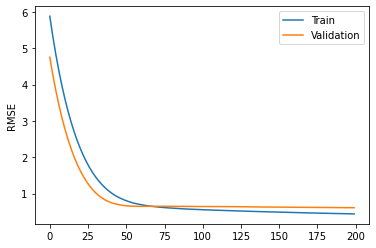

In [20]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Tune hyperparameters values and train model using .fit with Train data
# you can use l1 and l2 regularization terms too
# after training calculate Root Mean Square Error (RMSE) for validation data
#################################################################################
from sklearn.metrics import confusion_matrix
learning_rate = [0.05, 0.2]
n_estimators = [100, 200]
max_depth = [6, 10]
colsample_bytree = [0.5, 1]
subsample = [0.5, 1]

best_model = None
best_val_err = 1e9
best_f1_score = 0
for lr in learning_rate:
    for ne in n_estimators:
        for md in max_depth:
            for cb in colsample_bytree:
                for ss in subsample:
                    model = xgboost.XGBRegressor(objective ='reg:linear', learning_rate = lr, 
                                                 colsample_bytree = cb, max_depth = md, 
                                                 subsample = ss, n_estimators = ne,
                                                 eval_metric='rmse', silent=True)

                    model.fit(X_train,Y_train, eval_metric="rmse", eval_set=[(X_train, Y_train), (X_val, Y_val)],verbose=False)
                    y_pred = model.predict(X_val)
                    val_err = mean_squared_error(Y_val, y_pred)
                    TN, FP, FN, TP = confusion_matrix(np.where(Y_val > 7, 1, 0), np.where(y_pred > 7, 1, 0)).ravel()
                    val_precision = TP / (TP + FP)
                    val_recall = TP / (TP+FN)
                    val_f1 = 2*val_recall*val_precision/(val_recall + val_precision)
                    print("lr:%.2f, n_e:%d, m_d:%d, c_b:%.2f, s_s:%.2f --> val error: %f, f1 score: %f" %(lr, ne, md, cb, ss, val_err, val_f1))
                    if val_f1 > best_f1_score:
                        best_val_err = val_err
                        best_f1_score = val_f1
                        best_model = model

model = best_model
validation_rmse = best_val_err
#################################################################################
#                                   THE END                                     #
#################################################################################
print("Validation RMSE: %.3f" % validation_rmse)
plot_model_results(model.evals_result())

### 3.2 Ploting Feature importance

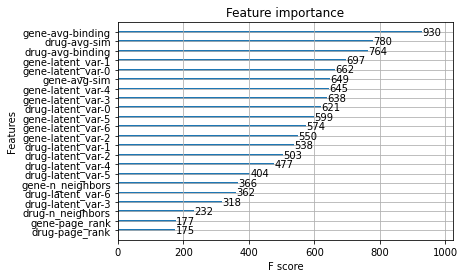

In [21]:
xgboost.plot_importance(model);

### 3.2 Evaluation

Let's make our perdiction binary. either a drug is binded to target or not, use $pK_d$ > 7 threshold as binded (drug-target) pair.

In [22]:
from sklearn.metrics import confusion_matrix

#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Calculate RMSE for Test data. after that
# Calculate accuracy, precision, recall, f1-score for X_test
# for binary prediction setting. you can use confution_matrix from sklearn
#################################################################################
y_pred = model.predict(X_test)
test_rmse = mean_squared_error(Y_test, y_pred)

y_pred = np.where(y_pred > 7, 1, 0)
TN, FP, FN, TP = confusion_matrix(np.where(Y_test > 7, 1, 0), y_pred).ravel()

test_acc = (TP + TN) / (TP+TN+FP+FN)
test_percision = TP / (TP + FP)
test_recall = TP / (TP+FN)
test_f1 = 2*test_recall*test_percision/(test_recall + test_percision)

#################################################################################
#                                   THE END                                     #
#################################################################################
print("Test RMSE: %.3f" % test_rmse)
print("Test Accuracy: %.3f" % test_acc)
print("Test Percision: %.3f" % test_percision)
print("Test Recall: %.3f" % test_recall)
print("Test F1-Score: %.3f" % test_f1)

Test RMSE: 0.398
Test Accuracy: 0.940
Test Percision: 0.683
Test Recall: 0.575
Test F1-Score: 0.624


## 4.Classification (25 Points)

Change Binding values to binary values with threshold $pK_d$ > 7 
and use X_train to train any Classifier method that you like.\
Report `accuracy`, `precision`, `recall`, `f1-score` for X_test. 



In [23]:
y_train = np.where(Y_train > 7, 1, 0)
y_val = np.where(Y_val > 7, 1, 0)
y_test = np.where(Y_test > 7, 1, 0)

In [24]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.ensemble import RandomForestClassifier

# my_model = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=1).fit(X_train, y_train)
# print(my_model.score(X_val, y_val))
n_estimators = [100,200]
learning_rate = [0.05, 0.2]
max_depth = [6, 10]

# rfc = RandomForestClassifier(n_estimators=20, max_depth = 10).fit(X_train, y_train)
# print(confusion_matrix(y_val, rfc.predict(X_val)).ravel())
# print(recall_score(y_val, rfc.predict(X_val)))
best_my_model = None
best_f1_val = 0
for ne in n_estimators:
    for lr in learning_rate:
        for md in max_depth:
            my_model2 = GradientBoostingClassifier(n_estimators=ne, learning_rate=lr, max_depth=md, random_state=1).fit(X_train, y_train)
            y_val_pred = my_model2.predict(X_val)
            TN, FP, FN, TP = confusion_matrix(y_val, y_val_pred).ravel()
            val_precision = TP / (TP + FP)
            val_recall = TP / (TP+FN)
            val_f1 = 2*val_recall*val_precision/(val_recall + val_precision)
            #print(val_f1)
#             print(confusion_matrix(y_val, my_model2.predict(X_val)).ravel(), ne, lr, md)
#             print(classification_report(y_val, my_model2.predict(X_val)))
#             print(recall_score(y_val, my_model2.predict(X_val)))
            #print(my_model2.score(X_val, y_val))
            if val_f1 > best_f1_val:
                best_my_model = my_model2
                best_f1_val = val_f1
                

y_test_pred = best_my_model.predict(X_test)

TN, FP, FN, TP = confusion_matrix(y_test, y_test_pred).ravel()

test_acc = (TP + TN) / (TP+TN+FP+FN)
test_percision = TP / (TP + FP)
test_recall = TP / (TP+FN)
test_f1 = 2*test_recall*test_percision/(test_recall + test_percision)

print("Test Accuracy: %.3f" % test_acc)
print("Test Percision: %.3f" % test_percision)
print("Test Recall: %.3f" % test_recall)
print("Test F1-Score: %.3f" % test_f1)
                                                                                                             

Test Accuracy: 0.921
Test Percision: 0.539
Test Recall: 0.659
Test F1-Score: 0.593


# Extra Points

There is 5 extra points in parts 3 & 4 rewarded to the top 15% students with the best results. Your model will be trained again with a random seed on our dataset. Please have in mind:
- You should only use train or validation data for training phase of your model.
- Your code must be readable and runnable in other enviroments.
- If you are going to use other libraries, mention them.